# Linear Regression in StatsModels

## Introduction

So far, you learned how linear regression and R-Squared (coefficient of determination) work "under the hood" and created your own versions using NumPy.

Going forward, you're going to use a Python library called StatsModels to do the modeling and evaluation work for you!

 
## Objectives

You will be able to:

* Perform a linear regression using StatsModels
* Evaluate a linear regression model using StatsModels 
* Interpret linear regression model coefficients using StatsModels

## What is StatsModels?

StatsModels is a powerful Python package for many types of statistical analyses. In particular, as you may have guessed from the name, StatsModels emphasizes statistical _modeling_, particular linear models and time series analysis. You can check out the [User Guide](https://www.statsmodels.org/stable/user-guide.html) for an overview of all of the available models.

![StatsModels logo](images/sm1.png)

When using StatsModels, we'll need to introduce one more set of terminology: ***endogenous*** and ***exogenous*** variables. You'll see these as argument names `endog` and `exog` in the [documentation](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html) for the models, including `OLS` (ordinary least squares linear regression). These are simply the names used by StatsModels for the independent and dependent variables.

This table is drawn from the [StatsModels documentation](https://www.statsmodels.org/stable/endog_exog.html):

| `endog`            | `exog`               |
| ------------------ | -------------------- |
| $y$                | $x$                  |
| dependent variable | independent variable |
| response variable  | explanatory variable |

## Importing Necessary Libraries

Most of the import statements below should already be familiar. The one new import statement is

```python
import statsmodels.api as sm
```

Going forward, `sm` refers to StatsModels.

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

Let's load a simple dataset for the purpose of understanding the process.

The dataset contains weight and height, and we'll set height as the independent variable (x) and weight as the dependent variable.

We'll start out by plotting them against each other in a scatter plot:

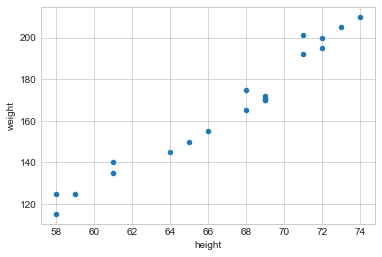

In [5]:
df = pd.read_csv('heightWeight.csv')
df.plot.scatter(x="height", y="weight");

Looks like a linear relationship!

## Building Our Linear Regression

One way to build a linear regression would be by hand, calculating $\hat{m}$ and $\hat{c}$ with the least-squares formula:

In [7]:
rho = np.corrcoef(df["height"], df["weight"])[0][1]
#s_y = df["weight"].std()
#s_x = df["height"].std()
s_y = np.std(df["height"])
s_x = np.std(df["weight"])
m = rho * s_y / s_x

mean_y = df["weight"].mean()
mean_x = df["height"].mean()
c = mean_y - m * mean_x

print(f"Our regression line is: y = {round(m, 5)}x + {round(c, 5)}")

Our regression line is: y = 0.17247x + 154.27044


In [8]:
## trying different code output
#to get m(slope) calculate rho * std_dev of y/ std_dev of x
rho =np.corrcoef(df["height"], df["weight"])[0][1]
std_dev_y = np.std(df["height"])
std_dev_x = np.std(df["weight"])

m = rho * std_dev_y / std_dev_x

mean_y = np.mean(df["weight"])
mean_x = np.mean(df["weight"])
c = mean_y - m * mean_x

print(f"Our linear regression line is: y = {round(m ,5)}x + {round(c,5)}")

Our linear regression line is: y = 0.17247x + 137.20462


That works, in a way. But now if we wanted to calculate the F-statistic, or R-Squared, or find the confidence intervals for the parameters, that would be a lot of additional calculations.

If we use StatsModels instead, all of the calculations are done for us! We just have to set up the appropriate x and y variables and plug them into a model.

### Determining `X` and `y` Variables

Technically you can subset a pandas dataframe in the same line where you create the model, but it tends to be easier if you specify your variables first.

In [10]:
X = df["height"]
y = df["weight"]

You might notice that `X` is capitalized and `y` is not. This is not a mistake! The idea is to indicate that `X` is a 2D matrix, and `y` is a 1D array. Currently `X` only has one value in it (height) but this will change when we get to multiple regression.

### Creating the Model

With StatsModels, the "model" is the result of calling the `OLS` constructor function.

We will also use the `add_constant` method because StatsModels expects a column of constant values if there should be a constant in the resulting regression.

In [11]:
model = sm.OLS(endog=y, exog=sm.add_constant(X))
model

### Fitting the Model

Once we have a model, we call the `fit` method, which returns a results object.

In [12]:
results = model.fit()
results

### Evaluating and Interpreting the Model

Now we can get all kinds of different information out of the model results!

***F-statistic and F-statistic p-value***

In [13]:
results.fvalue, results.f_pvalue

(384.7740288570766, 1.3461445985228785e-13)

**Interpretation:** Our model is statistically significant, with a p-value well below the standard alpha of 0.05

***R-Squared*** (coefficient of determination):

In [14]:
results.rsquared

0.9553099288673669

**Interpretation:** Our model explains about 95.5% of the variance in weight, the dependent variable

***Model parameters:***

In [15]:
results.params

const    -204.483436
height      5.539019
dtype: float64

**Interpretation:** For a height of 0, our model would predict a weight of about -204.5. An increase of 1 in height is associated with an increase of about 5.5 in weight.

Notes:

1. These are the same values we got from our "by hand" regression earlier! `m` corresponds to `height` in this output, and `c` corresponds to `const`
2. Intercept values are often nonsensical if a value of 0 in the independent variable is nonsensical. So don't worry too much about making sense of what a height of -204.5 for a weight of 0 means

***Model parameter p-values:***

In [16]:
results.pvalues

const     2.688182e-09
height    1.346145e-13
dtype: float64

**Interpretation:** Both of our model parameters (coefficient for `height` and intercept) are statistically significant, with p-values well below the standard alpha of 0.05.

***Model parameter confidence intervals:***

In [17]:
print(results.conf_int())

                 0           1
const  -244.252410 -164.714462
height    4.945766    6.132272


**Interpretation:** Our 95% confidence interval for the intercept is about -244.3 to about -164.7. Our 95% confidence interval for the coefficient of `height` is about 4.9 to about 6.1.

## The Results Summary

Instead of extracting these individual values from the results object, there is also a method `summary` that will print out all of this information at once. It can get overwhelming, but take a look and see if you can find all of the information extracted above:

* F-statistic and F-statistic p-value
* R-Squared (coefficient of determination)
* Parameters
* Parameter p-values
* Parameter confidence intervals

---

<details>
    <summary style="cursor: pointer"><b>Hints (click to reveal)</b></summary>
    
* F-statistic is located in the list on the upper right, `F-statistic:`
* F-statistic p-value is located in the list on the upper right, `Prob (F-statistic):`
* R-Squared (coefficient of determination) is located in the list on the upper right, `R-squared:`
* Parameters are in the middle, with the names (`const` and `height`) on the left
  * Their coefficients are listed under `coef`
  * Their p-values are listed under `P>|t|` (note that they appear as 0.000 due to rounding)
  * Their confidence intervals have the lower bound listed under `[0.025` and the upper bound listed under `0.975]`
    
</details>

In [18]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     384.8
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.35e-13
Time:                        22:02:04   Log-Likelihood:                -64.112
No. Observations:                  20   AIC:                             132.2
Df Residuals:                      18   BIC:                             134.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -204.4834     18.929    -10.802      0.0

You can also omit the `print` part to see a summary styled by the notebook. Different people may find the version above or below more readable; either are fine.

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     384.8
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.35e-13
Time:                        22:02:11   Log-Likelihood:                -64.112
No. Observations:                  20   AIC:                             132.2
Df Residuals:                      18   BIC:                             134.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -204.4834     18.929    -10.802      0.000    -244.252    -164.714
height         5.5390      0.282     19.616      0.000       4.946       6.132
==============================================================================
Omnibus:                        2.588   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.274   Jarque-Bera (JB):                1.245
Skew:                           0.202   Prob(JB):                        0.537
Kurtosis:                       1.846   Cond. No.                         902.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This summary contains a **lot** of information. If you're curious about all of the fields, feel free to expand the below explanation:

---

<details>
    <summary style="cursor: pointer"><b>Regression results explanation (click to expand)</b></summary>
    
The left part of the first table gives some specifics on the data and the model:

* **Dep. Variable**: Singular. Which variable is the point of interest of the model
* **Model**: Technique used, an abbreviated version of Method (see methods for more).
* **Method**: The loss function optimized in the parameter selection process. Least Squares since it picks the parameters that reduce the training error. This is also known as Mean Squared Error (MSE).
* **No. Observations**: The number of observations used by the model, or size of the training data.
* **Df Residuals**: Degrees of freedom of the residuals, which is the number of observations minus the number of parameters. Intercept is a parameter. The purpose of Degrees of Freedom is to reflect the impact of descriptive/summarizing statistics in the model, which in regression is the coefficient. Since the observations must "live up" to these parameters, they only have so many free observations, and the rest must be reserved to "live up" to the parameters' prophecy. This internal mechanism ensures that there are enough observations to match the parameters.
* **Df Model**: The number of parameters in the model (not including the constant/intercept term if present)
* **Covariance Type**: Robust regression methods are designed to be not overly affected by violations of assumptions by the underlying data-generating process. Since this model is Ordinary Least Squares, it is non-robust and therefore highly sensitive to outliers.
    
The right part of the first table shows the goodness of fit: 

* **R-squared**: The coefficient of determination, the Explained Sum of Squares divided by Total Sum of Squares. This translates to the percent of variance explained by the model. The remaining percentage represents the variance explained by error, the E term, the part that model and predictors fail to grasp.
* **Adj. R-squared**: Version of the R-Squared that penalizes additional independent variables. 
* **F-statistic**: A measure of how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals. Feeds into the calculation of the P-Value.
* **Prob (F-statistic)**: The probability that a sample like this would yield the above statistic, and whether the model's verdict on the null hypothesis will consistently represent the population. Does not measure effect magnitude, instead measures the integrity and consistency of this test on this group of data.
* **Log-likelihood**: The log of the likelihood function.
* **AIC**: The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model. Penalizes the model selection metrics when more independent variables are added.
* **BIC**: The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters. Penalizes the model selection metrics when more independent variables are added.

The second table shows the coefficient report: 

* **coef**: The estimated value of the coefficient. By how much the model multiplies the independent value by.
* **std err**: The basic standard error of the estimate of the coefficient. Average distance deviation of the points from the model, which offers a unit relevant way to gauge model accuracy.
* **t**: The t-statistic value. This is a measure of how statistically significant the coefficient is.
* **P > |t|**: P-value that the null-hypothesis that the coefficient = 0 is true. If it is less than the confidence level, often 0.05, it indicates that there is a statistically significant relationship between the term and the response.
* **[95.0% Conf. Interval]**: The lower and upper values of the 95% confidence interval. Specific range of the possible coefficient values.

The third table shows information about the residuals, autocorrelation, and multicollinearity: 

* **Skewness**: A measure of the symmetry of the data about the mean. Normally-distributed errors should be symmetrically distributed about the mean (equal amounts above and below the line). The normal distribution has 0 skew.
* **Kurtosis**: A measure of the shape of the distribution. Compares the amount of data close to the mean with those far away from the mean (in the tails), so model "peakiness". The normal distribution has a Kurtosis of 3, and the greater the number, the more the curve peaks.
* **Omnibus**: Provides a combined statistical test for the presence of skewness and kurtosis.
* **Prob(Omnibus)**: The above statistic turned into a probability
* **Jarque-Bera**: A different test of the skewness and kurtosis
* **Prob (JB)**: The above statistic turned into a probability
* **Durbin-Watson**: A test for the presence of autocorrelation (that the errors are not independent), which is often important in time-series analysis
* **Cond. No**: A test for multicollinearity (if in a fit with multiple parameters, the parameters are related to each other).

</details>

## Visualizing Our Model

### Plotting Fit

StatsModels also comes with some plotting utilities that are particularly useful for statistical modeling. You can find the full list [here](https://www.statsmodels.org/stable/graphics.html#regression-plots).

This method shows the scatter plot of actual values as well as points indicating the values predicted by the model. The black vertical lines represent the confidence intervals for each prediction. (These confidence intervals use the t-distribution.)

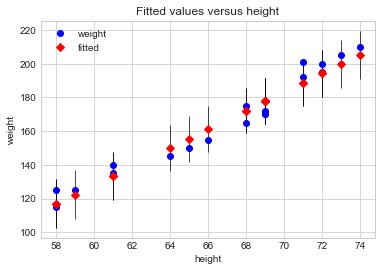

In [20]:
sm.graphics.plot_fit(results, "height")
plt.show()

For a simpler visualization, you can use `abline_plot` from StatsModels to add a best-fit line to a regular scatter plot.

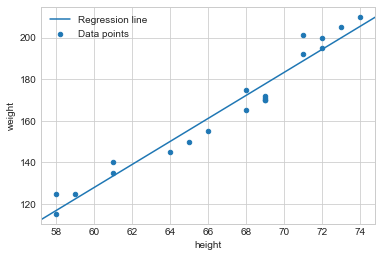

In [21]:
fig, ax = plt.subplots()
df.plot.scatter(x="height", y="weight", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=results, label="Regression line", ax=ax)
ax.legend();

There is also a Seaborn function, `regplot` ([documentation here](https://seaborn.pydata.org/generated/seaborn.regplot.html)), that can be useful for visualizing the original data alongside the regression line. In this case the shaded region also represents the confidence interval, which is computed using a different technique called bootstrapping.

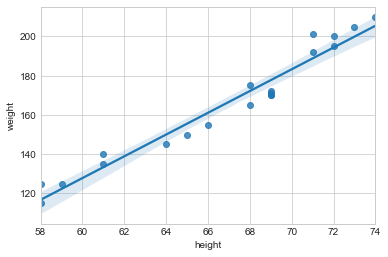

In [22]:
sns.regplot(x="height", y="weight", data=df);

### Plotting Residuals

Model residuals are the differences between the true values and the values predicted by the model. We can get them easily from the model results using the `resid` attribute.

In [23]:
results.resid

0     -7.169872
1     12.213070
2      6.603263
3     -7.708891
4      3.213070
5      8.220320
6      0.674051
7      5.135032
8     -1.779680
9      4.596012
10     1.603263
11     2.681301
12    -5.708891
13     2.830128
14    -5.013795
15    -7.708891
16     5.674051
17    -6.091834
18    -5.552814
19    -6.708891
dtype: float64

As you can see, model residuals can be negative or positive depending on whether the model guessed too high or too low of a value.

The most typical way to plot the model residuals is like this:

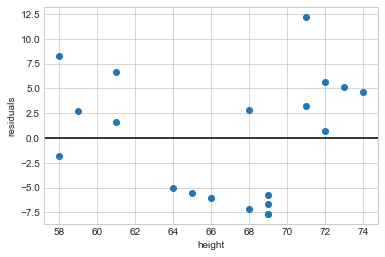

In [25]:
fig, ax = plt.subplots()

ax.scatter(df["height"], results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("height")
ax.set_ylabel("residuals");

We also might be interested in the distribution of the residuals, which we could plot using a histogram:

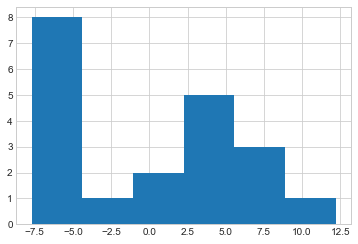

In [26]:
plt.hist(results.resid, bins="auto");

Another tool we might use to visualize the distribution of the residuals is called a Q-Q plot. It compares the quantiles of the residuals to the quantiles of a theoretical normal distribution. The farther from the line that the data points appear, the farther from a normal distribution they are.

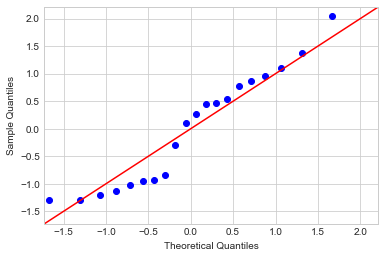

In [27]:
sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
plt.show()

#### Why Visualize Residuals?

The main purpose of visualizing the residuals is to help you better understand where your model is performing well, and where it is performing poorly. For example, some models perform better on smaller values than larger values.

You might use this information to improve the model, or simply to communicate transparently about its strengths and weaknesses. These plots will also become relevant when investigating whether the model assumptions are being met.

## R-Style Regression Formulas

We have been using the primary (`api`) interface to StatsModels. There is also an interface (`formula.api`) that uses R-style formulas. R-style meaning that the formulas for the models are written in the same style as they would be written in the programming language [R](https://en.wikipedia.org/wiki/R_(programming_language)).

Unlike Python, R has built-in functionality for linear modeling, and so you will find that some foundational statistics and data science resources and papers used R rather than Python. StatsModels includes this R-style interface to be more convenient for people who learned R first. You can read more about it [here](https://www.statsmodels.org/stable/example_formulas.html).

Below we provide an example of the same model above, except developed using an R-style formula.

In [28]:
import statsmodels.formula.api as smf

rstyle_model = smf.ols(formula="weight ~ height", data=df)
rstyle_results = rstyle_model.fit()
print(rstyle_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     384.8
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.35e-13
Time:                        22:16:32   Log-Likelihood:                -64.112
No. Observations:                  20   AIC:                             132.2
Df Residuals:                      18   BIC:                             134.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -204.4834     18.929    -10.802      0.0

The only difference in the results between using the R-style formula `ols` and the `OLS` we used previously is that one of the parameters is called `Intercept` rather than `const`. This is because `ols` automatically adds a constant to the `X` values, whereas with `OLS` you need to use `sm.add_constant`. Both forms result in an intercept term, they just have different names.

In general, we recommend using the `OLS` interface rather than the R-style formula interface because building the formula can get increasingly complicated as we move from simple linear regression to multiple regression. But you may see examples using either, so it's useful to be able to interpret both forms.

## Summary

Now you know how to run a simple linear regression in StatsModels. After creating and fitting the model, you used attributes of the results object as well as the model summary to evaluate the model performance and interpret the values of its coefficients. You also saw some examples of visualizations to represent model performance, including some visualization tools directly from StatsModels.